<a href="https://colab.research.google.com/github/bonareri/Cryptocurrency-Price-Prediction-/blob/main/lstm_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Understanding the Dataset

In [1]:
#Importing necesseray libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
import requests
import joblib
import math
import datetime as dt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# import keras_tuner as kt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
# Set the Seaborn style for all plots
sns.set_style("darkgrid")

In [18]:
# Define the coins and their tickers
COINS = {
    "bitcoin": "BTC-USD",
    "ethereum": "ETH-USD",
    "solana": "SOL-USD",
    "tether": "USDT-USD",  # Added USDT
    "xrp": "XRP-USD",      # Added XRP
    "binancecoin": "BNB-USD" # Added BNB
}

# Function to fetch historical price data
def fetch_crypto_data(coin_id, ticker):
    print(f"Fetching data for {coin_id.upper()}...")

    crypto = yf.Ticker(ticker)
    df = crypto.history(period="max")

    if df.empty:
        print(f"Error: No historical data found for {coin_id}.")
        return None

    # Format data
    df.reset_index(inplace=True)
    df["Date"] = pd.to_datetime(df["Date"]).dt.strftime('%Y-%m-%d')

    # Keep relevant columns
    df = df[["Date", "Close", "High", "Low", "Open", "Volume"]]

    return df

# Main function
def main():
    for coin_id, ticker in COINS.items():
        df = fetch_crypto_data(coin_id, ticker)
        if df is not None:
            filename = f"{coin_id}_prices.csv"
            df.to_csv(filename, index=False)
            print(f"Data saved to {filename}")

if __name__ == "__main__":
    main()


Fetching data for BITCOIN...
Data saved to bitcoin_prices.csv
Fetching data for ETHEREUM...
Data saved to ethereum_prices.csv
Fetching data for SOLANA...
Data saved to solana_prices.csv
Fetching data for TETHER...
Data saved to tether_prices.csv
Fetching data for XRP...
Data saved to xrp_prices.csv
Fetching data for BINANCECOIN...
Data saved to binancecoin_prices.csv


In [28]:
#List of Coins
coins = ["bitcoin", "ethereum", "solana", "tether", "xrp", "binancecoin"]

#Dictionary to store dataframes
crypto_data = {}

#Load csv files dynamically
for coin in coins:
  filename = f"{coin}_prices.csv"
  crypto_data[coin] = pd.read_csv(filename)

In [29]:
for coin, df in crypto_data.items():
  print(f"\n First 5 rows of {coin.capitalize()} data:")
  print(df.head())


 First 5 rows of Bitcoin data:
         Date       Close        High         Low        Open    Volume
0  2014-09-17  457.334015  468.174011  452.421997  465.864014  21056800
1  2014-09-18  424.440002  456.859985  413.104004  456.859985  34483200
2  2014-09-19  394.795990  427.834991  384.532013  424.102997  37919700
3  2014-09-20  408.903992  423.295990  389.882996  394.673004  36863600
4  2014-09-21  398.821014  412.425995  393.181000  408.084991  26580100

 First 5 rows of Ethereum data:
         Date       Close        High         Low        Open      Volume
0  2017-11-09  320.884003  329.451996  307.056000  308.644989   893249984
1  2017-11-10  299.252991  324.717987  294.541992  320.670990   885985984
2  2017-11-11  314.681000  319.453003  298.191986  298.585999   842300992
3  2017-11-12  307.907990  319.153015  298.513000  314.690002  1613479936
4  2017-11-13  316.716003  328.415009  307.024994  307.024994  1041889984

 First 5 rows of Solana data:
         Date     Close     

In [30]:
for coin, df in crypto_data.items():
  print(f"\n Overview of {coin.capitalize()} data:")
  print(df.info())


 Overview of Bitcoin data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3832 entries, 0 to 3831
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3832 non-null   object 
 1   Close   3832 non-null   float64
 2   High    3832 non-null   float64
 3   Low     3832 non-null   float64
 4   Open    3832 non-null   float64
 5   Volume  3832 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 179.8+ KB
None

 Overview of Ethereum data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2683 entries, 0 to 2682
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2683 non-null   object 
 1   Close   2683 non-null   float64
 2   High    2683 non-null   float64
 3   Low     2683 non-null   float64
 4   Open    2683 non-null   float64
 5   Volume  2683 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 125.9+ KB
None



In [31]:
# Create a new dictionary to store cleaned data
cleaned_data = {}

for coin, df in crypto_data.items():
    # Convert 'Date' to datetime format
    df["Date"] = pd.to_datetime(df["Date"])

    # Set 'Date' as the index
    df.set_index("Date", inplace=True)

    # Store cleaned data in a new dictionary to avoid modifying while iterating
    cleaned_data[coin] = df

    # Print DataFrame info separately to avoid returning None
    print(f"\nCleaned {coin.capitalize()} data:")
    df.info()

# Assign the cleaned data back to the original dictionary
crypto_data = cleaned_data


Cleaned Bitcoin data:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3832 entries, 2014-09-17 to 2025-03-14
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3832 non-null   float64
 1   High    3832 non-null   float64
 2   Low     3832 non-null   float64
 3   Open    3832 non-null   float64
 4   Volume  3832 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 179.6 KB

Cleaned Ethereum data:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2683 entries, 2017-11-09 to 2025-03-14
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2683 non-null   float64
 1   High    2683 non-null   float64
 2   Low     2683 non-null   float64
 3   Open    2683 non-null   float64
 4   Volume  2683 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.8 KB

Cleaned Solana data:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1800 ent

## 2. Data Preprocessing

In [32]:
#Dictionary to store close price
crypto_close = {}

#Select only close for each coin
for coin, df in crypto_data.items():
  crypto_close[coin] = df["Close"]

In [33]:
for coin, df in crypto_close.items():
  print(f"\n First 5 rows of {coin.capitalize()} close prices:")
  print(df.head())


 First 5 rows of Bitcoin close prices:
Date
2014-09-17    457.334015
2014-09-18    424.440002
2014-09-19    394.795990
2014-09-20    408.903992
2014-09-21    398.821014
Name: Close, dtype: float64

 First 5 rows of Ethereum close prices:
Date
2017-11-09    320.884003
2017-11-10    299.252991
2017-11-11    314.681000
2017-11-12    307.907990
2017-11-13    316.716003
Name: Close, dtype: float64

 First 5 rows of Solana close prices:
Date
2020-04-10    0.951054
2020-04-11    0.776819
2020-04-12    0.882507
2020-04-13    0.777832
2020-04-14    0.661925
Name: Close, dtype: float64

 First 5 rows of Tether close prices:
Date
2017-11-09    1.00818
2017-11-10    1.00601
2017-11-11    1.00899
2017-11-12    1.01247
2017-11-13    1.00935
Name: Close, dtype: float64

 First 5 rows of Xrp close prices:
Date
2017-11-09    0.217488
2017-11-10    0.206483
2017-11-11    0.210430
2017-11-12    0.197339
2017-11-13    0.203442
Name: Close, dtype: float64

 First 5 rows of Binancecoin close prices:
Date
2

## Train Test Split

In [ ]:
# Function to split data into 80% training and 20% testing
def split_data(df_close):
    train_size = int(len(df_close) * 0.8)  # 80% of data
    df_train = df_close[:train_size].values  # Training set
    df_test = df_close[train_size:].values   # Testing set
    return df_train, df_test

# Split data for each cryptocurrency
btc_train, btc_test = split_data(btc_close)
eth_train, eth_test = split_data(eth_close)
sol_train, sol_test = split_data(sol_close)

# Print data shapes
print(f"Bitcoin - Train: {btc_train.shape}, Test: {btc_test.shape}")
print(f"Ethereum - Train: {eth_train.shape}, Test: {eth_test.shape}")
print(f"Solana - Train: {sol_train.shape}, Test: {sol_test.shape}")

Bitcoin - Train: (3043, 1), Test: (761, 1)
Ethereum - Train: (2124, 1), Test: (531, 1)
Solana - Train: (1417, 1), Test: (355, 1)


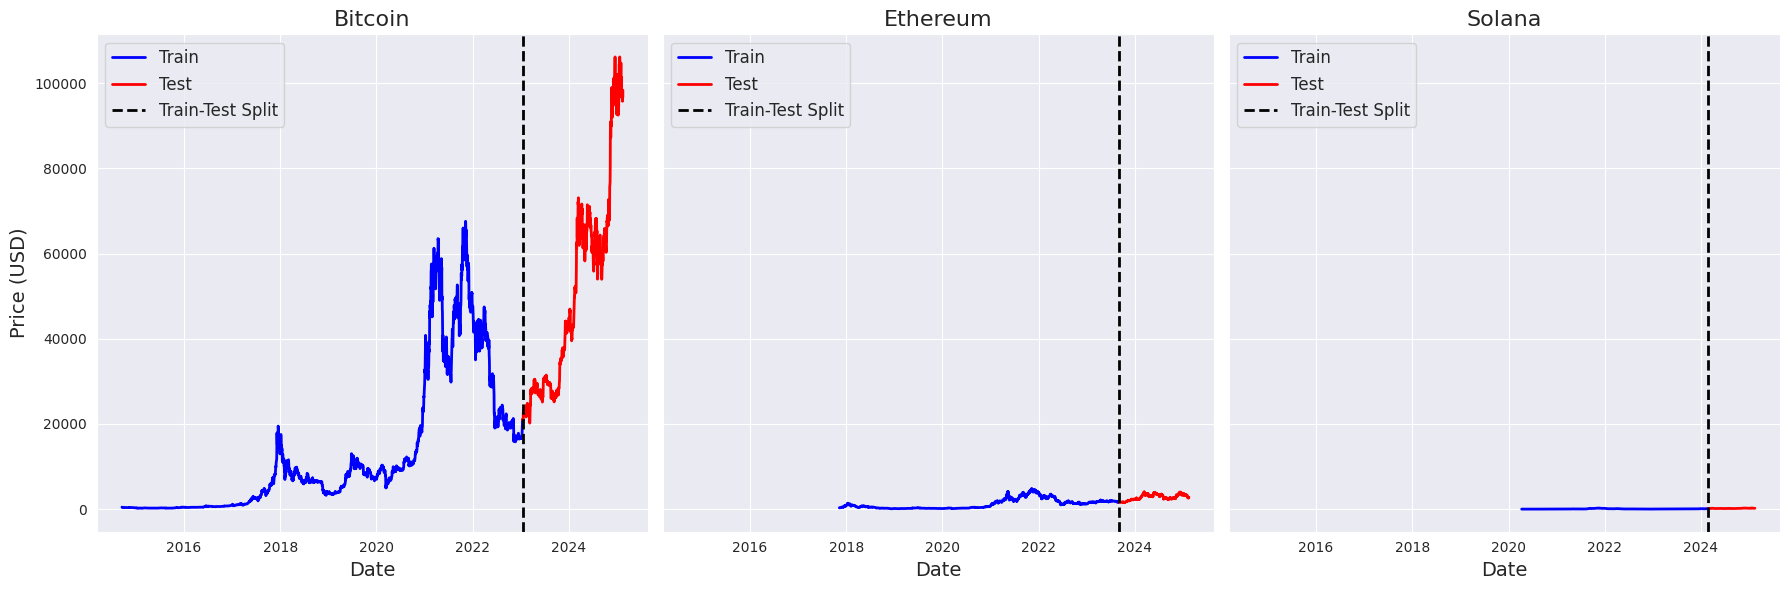

In [ ]:
import matplotlib.pyplot as plt

# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Process and plot for each cryptocurrency
for ax, (coin_name, df) in zip(axes, [('Bitcoin', btc_close), ('Ethereum', eth_close), ('Solana', sol_close)]):
    df_train, df_test = split_data(df)  # Split data
    train_size = len(df_train)  # Get split index

    # Plot training data
    ax.plot(df.index[:train_size], df_train, label='Train', linewidth=2, color='blue')

    # Plot test data
    ax.plot(df.index[train_size:], df_test, label='Test', linewidth=2, color='red')

    # Add vertical split line
    ax.axvline(df.index[train_size], color='black', linestyle='--', linewidth=2, label='Train-Test Split')

    # Set title
    ax.set_title(f'{coin_name}', fontsize=16)

    # Labels (only for the leftmost plot)
    if ax == axes[0]:
        ax.set_ylabel('Price (USD)', fontsize=14)

    # Set x-label for all plots
    ax.set_xlabel('Date', fontsize=14)
    ax.legend(loc='best', fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

### Feature Scaling

<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> Min Max Scaling of Data post Train-Test Split </h3>
</div>

I ensured that scaling is done only after splitting the data into training and test sets, with each set being scaled separately.

Performing normalization on the data before splitting it is problematic because the scaling process would use the entire dataset — including the test set — as a reference.

This inadvertently causes data leakage from the test set into the training data, leading to unrealistic model performance and potential overfitting. By scaling only after the split, I ensured that the test set remained unseen and untouched during training, which is crucial for accurate model evaluation.










In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize a single MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Function to scale train and test data
def scale_data(df_train, df_test):
    df_train = df_train.reshape(-1, 1)  # Ensure correct shape
    df_test = df_test.reshape(-1, 1)

    # Fit on training data & transform both train and test sets
    scaled_train = scaler.fit_transform(df_train)
    scaled_test = scaler.transform(df_test)

    return scaled_train, scaled_test

# Scale each cryptocurrency dataset
btc_scaled_train, btc_scaled_test = scale_data(btc_train, btc_test)
eth_scaled_train, eth_scaled_test = scale_data(eth_train, eth_test)
sol_scaled_train, sol_scaled_test = scale_data(sol_train, sol_test)

# Print shapes and min-max values for confirmation
for coin, train, test in zip(
    ["Bitcoin", "Ethereum", "Solana"],
    [btc_scaled_train, eth_scaled_train, sol_scaled_train],
    [btc_scaled_test, eth_scaled_test, sol_scaled_test]
):
    print(f"{coin} - Scaled Train Shape: {train.shape}, Min: {train.min():.4f}, Max: {train.max():.4f}")
    print(f"{coin} - Scaled Test Shape: {test.shape}, Min: {test.min():.4f}, Max: {test.max():.4f}")
    print("-" * 50)

Bitcoin - Scaled Train Shape: (3043, 1), Min: 0.0000, Max: 1.0000
Bitcoin - Scaled Test Shape: (761, 1), Min: 0.2969, Max: 1.5725
--------------------------------------------------
Ethereum - Scaled Train Shape: (2124, 1), Min: 0.0000, Max: 1.0000
Ethereum - Scaled Test Shape: (531, 1), Min: 0.3078, Max: 0.8423
--------------------------------------------------
Solana - Scaled Train Shape: (1417, 1), Min: 0.0000, Max: 1.0000
Solana - Scaled Test Shape: (355, 1), Min: 0.4174, Max: 1.0114
--------------------------------------------------


In [ ]:
# Save scalers for each cryptocurrency
joblib.dump(btc_scaler, "btc_scaler.pkl")
joblib.dump(eth_scaler, "eth_scaler.pkl")
joblib.dump(sol_scaler, "sol_scaler.pkl")

print("Scalers saved successfully for Bitcoin, Ethereum, and Solana!")

Scalers saved successfully for Bitcoin, Ethereum, and Solana!


<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> Time Series Windowing (Sequence Generation) </h3>
</div>

Since I’m working with **time series data**, I need the LSTM model to learn from **sequential patterns** instead of treating each data point independently.  

Time series windowing transforms raw time series data into **input-output pairs** so that the model can learn from historical data and make accurate future predictions.  

---

**Steps I Took**  

**1️⃣ Defined a Look-Back Window (Sliding Window)**  
I set a **look-back period** (`look_back = 5`), meaning the model will use the **past 5 days' prices** to predict the **next day's price**.  
This helps capture short-term trends in the data.

 Example:  


For example, given a sequence like [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], the data will be split into samples like:

```python

Input 				| Output
1, 2, 3, 4, 5 		6
2, 3, 4, 5, 6 		7
3, 4, 5, 6, 7 		8

```
**2️⃣ Created Input (X) and Output (y) Pairs**  
I looped through the **scaled dataset** and extracted:  
- **X** → The past `look_back` days (input sequence).  
- **y** → The next day's value (target label).  



In [ ]:
import numpy as np

# Function to create LSTM sequences
def create_sequences(dataset, look_back=5):
    """
    Generates input-output pairs for LSTM.

    Args:
        dataset (numpy.ndarray): Scaled dataset.
        look_back (int): Number of previous timesteps used for prediction.

    Returns:
        tuple: Feature sequences (X) and target values (y).
    """
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])  # Past `look_back` values
        y.append(dataset[i + look_back, 0])  # The next value (target)

    return np.array(X), np.array(y)

# Define look_back period (e.g., 5 days)
look_back = 5

# Dictionary to store sequences for each cryptocurrency
train_sequences, test_sequences = {}, {}

# List of cryptocurrencies and their scaled data
coins = ["Bitcoin", "Ethereum", "Solana"]
train_data = [btc_scaled_train, eth_scaled_train, sol_scaled_train]
test_data = [btc_scaled_test, eth_scaled_test, sol_scaled_test]

# Process each cryptocurrency
for coin, train, test in zip(coins, train_data, test_data):
    train_sequences[coin] = create_sequences(train, look_back)
    test_sequences[coin] = create_sequences(test, look_back)

# Extract sequences for each coin
btc_trainX, btc_trainY = train_sequences["Bitcoin"]
btc_testX, btc_testY = test_sequences["Bitcoin"]

eth_trainX, eth_trainY = train_sequences["Ethereum"]
eth_testX, eth_testY = test_sequences["Ethereum"]

sol_trainX, sol_trainY = train_sequences["Solana"]
sol_testX, sol_testY = test_sequences["Solana"]

# Print shapes for confirmation
print(f"Bitcoin - TrainX: {btc_trainX.shape}, TrainY: {btc_trainY.shape}")
print(f"Ethereum - TrainX: {eth_trainX.shape}, TrainY: {eth_trainY.shape}")
print(f"Solana - TrainX: {sol_trainX.shape}, TrainY: {sol_trainY.shape}")

Bitcoin - TrainX: (3038, 5), TrainY: (3038,)
Ethereum - TrainX: (2119, 5), TrainY: (2119,)
Solana - TrainX: (1412, 5), TrainY: (1412,)


### Reshaping Data (LSTM Format)

- Convert trainX & testX into (samples, time steps, features) format for LSTM.
- **Samples**: The total number of data points (`len(dataX)`).
- **Time steps**: The width of the sliding window (e.g., 5 in this case).
- **Features**: The number of features per time step. For example, in predicting Bitcoin price, the feature is 1 (the price at that time step).
- LSTM expects 3D inputs.

In [ ]:
# Reshape trainX and testX for each cryptocurrency (samples, time steps, features)
btc_trainX = btc_trainX.reshape(btc_trainX.shape[0], btc_trainX.shape[1], 1)
btc_testX = btc_testX.reshape(btc_testX.shape[0], btc_testX.shape[1], 1)

eth_trainX = eth_trainX.reshape(eth_trainX.shape[0], eth_trainX.shape[1], 1)
eth_testX = eth_testX.reshape(eth_testX.shape[0], eth_testX.shape[1], 1)

sol_trainX = sol_trainX.reshape(sol_trainX.shape[0], sol_trainX.shape[1], 1)
sol_testX = sol_testX.reshape(sol_testX.shape[0], sol_testX.shape[1], 1)

# Print shapes for verification
for coin, trainX, trainY, testX, testY in zip(
    ["Bitcoin", "Ethereum", "Solana"],
    [btc_trainX, eth_trainX, sol_trainX],
    [btc_trainY, eth_trainY, sol_trainY],
    [btc_testX, eth_testX, sol_testX],
    [btc_testY, eth_testY, sol_testY]
):
    print(f"{coin} - TrainX shape: {trainX.shape}, TrainY shape: {trainY.shape}")
    print(f"{coin} - TestX shape: {testX.shape}, TestY shape: {testY.shape}")
    print("-" * 50)

Bitcoin - TrainX shape: (3038, 5, 1), TrainY shape: (3038,)
Bitcoin - TestX shape: (756, 5, 1), TestY shape: (756,)
--------------------------------------------------
Ethereum - TrainX shape: (2119, 5, 1), TrainY shape: (2119,)
Ethereum - TestX shape: (526, 5, 1), TestY shape: (526,)
--------------------------------------------------
Solana - TrainX shape: (1412, 5, 1), TrainY shape: (1412,)
Solana - TestX shape: (350, 5, 1), TestY shape: (350,)
--------------------------------------------------


<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> LSTM (Long Short-Term Memory) Mechanism </h3>
</div>

LSTM is a type of recurrent neural network (RNN) designed to overcome the vanishing gradient problem. It uses internal gates to regulate information flow, enabling effective backpropagation through time (BPTT).

#### LSTM Layers in Keras
- LSTM layers can be created using the `LSTM()` class in Keras.
- Each LSTM cell has an internal **cell state** (`c`) and a **hidden state** (`h`).
- The `input_shape` for LSTM is `(timesteps, n_features)`, e.g., `(95000, 360)`.
- Keras LSTM expects inputs in the shape: `(n_examples, n_timesteps, n_features)`.

#### `return_sequences=True`
- Enables stacking of multiple LSTM layers.
- Ensures the second LSTM layer receives a compatible n-dimensional sequence input.
- Outputs one value per time step when set to `True`.

#### Why Increase LSTM Depth?
- **Enhances feature abstraction**: Similar to deep learning, deeper LSTMs recombine learned representations to capture complex patterns.
- **Efficient training**: Deeper networks often require fewer neurons and train faster.
- **Temporal abstraction**: Stacking LSTM layers allows models to process sequences at different time scales.

Stacked LSTMs have become a standard approach for complex sequence prediction tasks.


In [ ]:
# Define Early Stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Function to build an LSTM model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(units=50, return_sequences=True, activation='tanh',
             kernel_regularizer=l2(0.001), input_shape=input_shape),
        Dropout(0.3),  # Increased dropout

        LSTM(units=40, return_sequences=False, activation='tanh',
             kernel_regularizer=l2(0.001)),
        Dropout(0.3),

        Dense(units=30, activation='relu'),
        Dense(units=1)  # Output layer (linear activation for regression)
    ])

    # Compile the model with a lower learning rate
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

    return model

# Dictionary to store trained models and training history
models = {}
histories = {}

# Train a model for each cryptocurrency
for coin, trainX, trainY, testX, testY in zip(
    ["Bitcoin", "Ethereum", "Solana"],
    [btc_trainX, eth_trainX, sol_trainX],
    [btc_trainY, eth_trainY, sol_trainY],
    [btc_testX, eth_testX, sol_testX],
    [btc_testY, eth_testY, sol_testY]
):
    print(f"\nTraining LSTM Model for {coin}...\n")

    # Build model
    model = build_lstm_model(input_shape=(trainX.shape[1], 1))

    # Train model
    history = model.fit(
        trainX, trainY,
        epochs=100,
        batch_size=64,  # Increased batch size
        validation_data=(testX, testY),
        callbacks=[early_stopping],
        verbose=1
    )

    # Store the trained model and training history
    models[coin] = model
    histories[coin] = history

    print(f"\nFinished training {coin} model.\n" + "-" * 50)


Training LSTM Model for Bitcoin...



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.1519 - val_loss: 0.1613
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0636 - val_loss: 0.0416
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0390 - val_loss: 0.0297
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0282 - val_loss: 0.0217
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0201 - val_loss: 0.0162
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0153 - val_loss: 0.0143
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0111 - val_loss: 0.0117
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0088 - val_loss: 0.0072
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0070 - val_loss: 0.0081
Epoch 10/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0060 - val_loss: 0.0067
Epoch 11/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0049 - val_loss: 0.0058
Epoch 12/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss:

In [ ]:
# Print model summaries for each cryptocurrency
for coin, model in models.items():
    print(f"\nModel Summary for {coin}:\n")
    model.summary()
    print("-" * 50)


Model Summary for Bitcoin:



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 5, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 40)                  │          14,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 30)                  │           1,230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,665 (307.29 KB)

 Trainable params: 26,221 (102.43 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 52,444 (204.86 KB)

--------------------------------------------------

Model Summary for Ethereum:



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 5, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 5, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 40)                  │          14,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 30)                  │           1,230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,665 (307.29 KB)

 Trainable params: 26,221 (102.43 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 52,444 (204.86 KB)

--------------------------------------------------

Model Summary for Solana:



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 5, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 5, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 40)                  │          14,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 30)                  │           1,230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,665 (307.29 KB)

 Trainable params: 26,221 (102.43 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 52,444 (204.86 KB)

--------------------------------------------------


In [ ]:
# Save trained models for each cryptocurrency
for coin, model in models.items():
    model.save(f"{coin.lower()}_lstm_model.keras")
    print(f"Saved {coin} LSTM model as {coin.lower()}_lstm_model.keras")

Saved Bitcoin LSTM model as bitcoin_lstm_model.keras
Saved Ethereum LSTM model as ethereum_lstm_model.keras
Saved Solana LSTM model as solana_lstm_model.keras


## Model Evaluation

### Evaluate Model on Test Data

In [ ]:
# Evaluate each model's performance on its respective test data
for coin, model in models.items():
    testX, testY = test_sequences[coin]  # Get test data for the coin
    test_loss = model.evaluate(testX, testY, verbose=1)
    print(f"{coin} Test Loss (MSE): {test_loss:.6f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018
Test Loss (MSE): 0.002442


### Plot Training & Validation Loss Curves

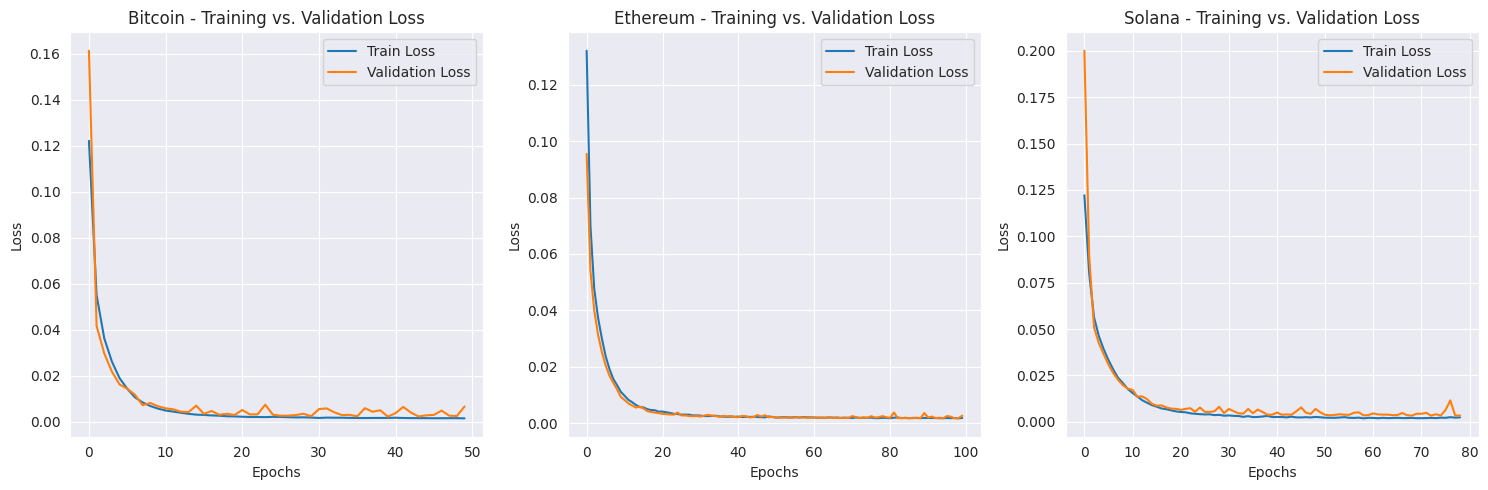

In [ ]:
# Plot training and validation loss separately for each cryptocurrency
coins = ["Bitcoin", "Ethereum", "Solana"]

plt.figure(figsize=(15, 5))

for i, coin in enumerate(coins, 1):
    plt.subplot(1, 3, i)  # Create subplots in a row
    plt.plot(histories[coin].history['loss'], label='Train Loss')
    plt.plot(histories[coin].history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{coin} - Training vs. Validation Loss')
    plt.legend()

plt.tight_layout()
plt.show()

### Generate Predictions & Inverse Transform

In [ ]:
# Load saved scalers for each cryptocurrency
scalers = {
    "Bitcoin": joblib.load("btc_scaler.pkl"),
    "Ethereum": joblib.load("eth_scaler.pkl"),
    "Solana": joblib.load("sol_scaler.pkl")
}

# Dictionary to store actual and predicted values
predictions = {}
actual_values = {}

# Predict and inverse transform for each coin
for coin in ["Bitcoin", "Ethereum", "Solana"]:
    model = models[coin]  # Access trained model for each coin
    scaler = scalers[coin]  # Access corresponding scaler

    # Predict using the respective model
    predicted = model.predict(test_sequences[coin][0])  # testX

    # Inverse transform predictions and actual values
    predictions[coin] = scaler.inverse_transform(predicted)
    actual_values[coin] = scaler.inverse_transform(test_sequences[coin][1].reshape(-1, 1))  # testY

    print(f"{coin} - Predictions Shape: {predictions[coin].shape}, Actual Shape: {actual_values[coin].shape}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Bitcoin - Predictions Shape: (756, 1), Actual Shape: (756, 1)
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Ethereum - Predictions Shape: (526, 1), Actual Shape: (526, 1)
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Solana - Predictions Shape: (350, 1), Actual Shape: (350, 1)


### Performance Metrics (RMSE & MAE)

In [ ]:
# Function to evaluate the model
def evaluate_model(actual, predicted, coin_name):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)

    print(f"Model Evaluation for {coin_name}:")
    print(f"➡️ Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"➡️ Mean Absolute Error (MAE): {mae:.4f}")
    print("-" * 50)

# Evaluate models for each cryptocurrency
for coin in ["Bitcoin", "Ethereum", "Solana"]:
    evaluate_model(actual_values[coin], predictions[coin], coin)


Model Evaluation for Bitcoin:
➡️ Root Mean Squared Error (RMSE): 2832.3956
➡️ Mean Absolute Error (MAE): 2147.0221
--------------------------------------------------
Model Evaluation for Ethereum:
➡️ Root Mean Squared Error (RMSE): 174.2365
➡️ Mean Absolute Error (MAE): 125.9807
--------------------------------------------------
Model Evaluation for Solana:
➡️ Root Mean Squared Error (RMSE): 13.7181
➡️ Mean Absolute Error (MAE): 10.4778
--------------------------------------------------


### Plot Actual vs. Predicted Values

In [ ]:
df['Date'] = df.index

<ipython-input-58-b85e6c7d4b48>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df.index


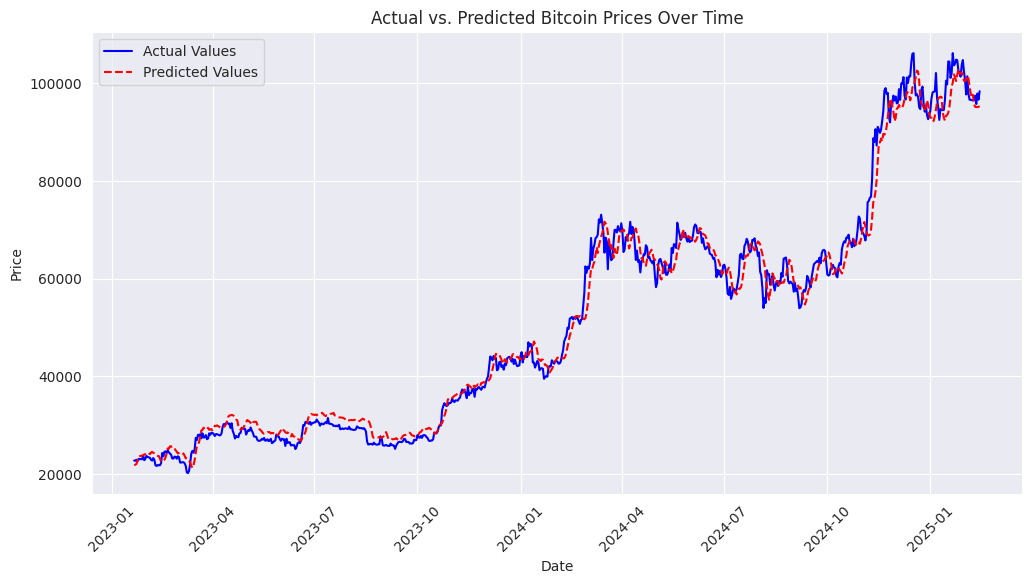

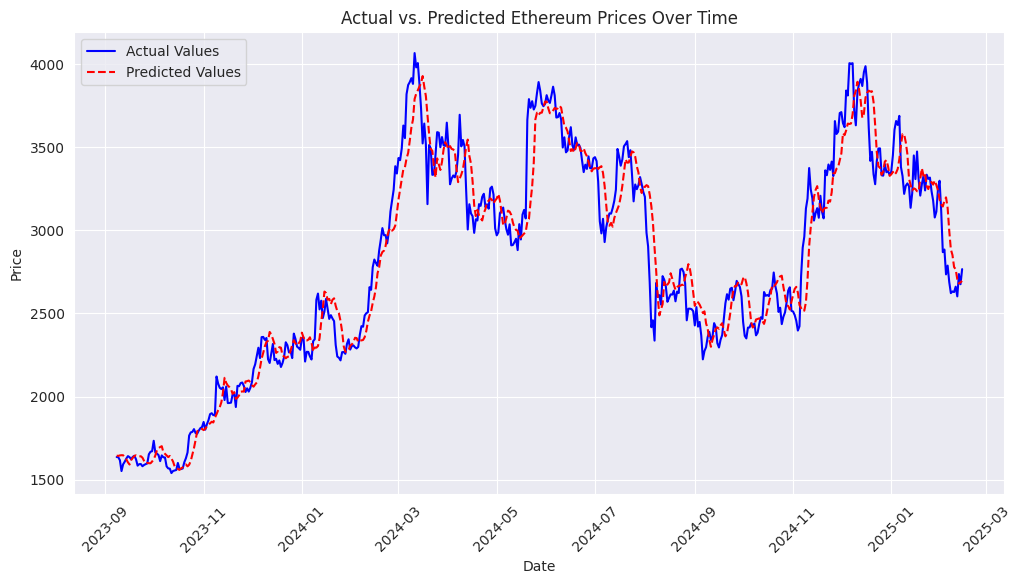

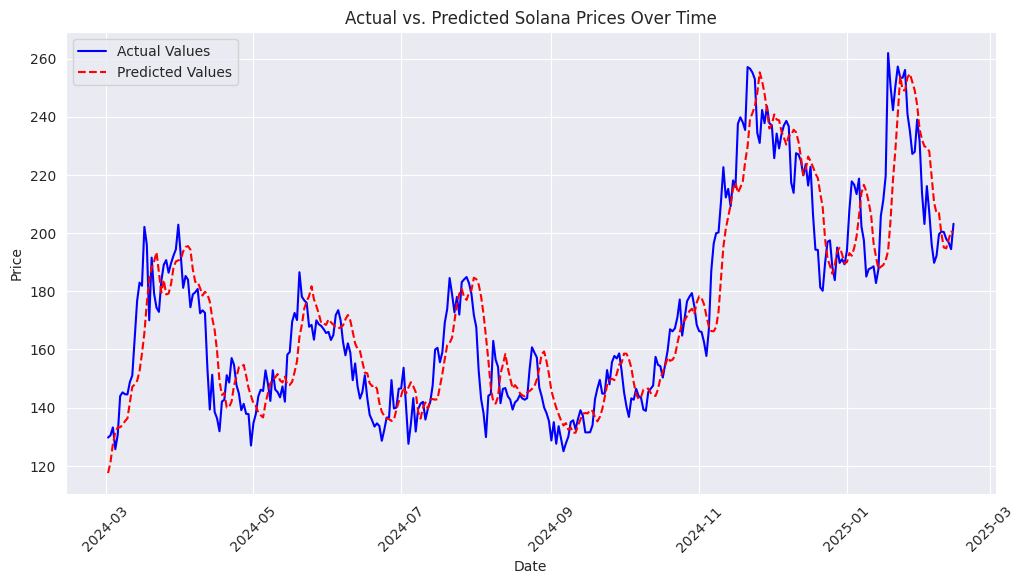

In [ ]:
import matplotlib.pyplot as plt

# Plot actual vs. predicted values for each cryptocurrency
for coin in ["Bitcoin", "Ethereum", "Solana"]:
    plt.figure(figsize=(12, 6))

    # Plot actual values
    plt.plot(df['Date'][-len(actual_values[coin]):], actual_values[coin],
             label="Actual Values", color='blue', linestyle='solid')

    # Plot predicted values
    plt.plot(df['Date'][-len(predictions[coin]):], predictions[coin],
             label="Predicted Values", color='red', linestyle='dashed')

    # Graph labels
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title(f"Actual vs. Predicted {coin} Prices Over Time")
    plt.legend()
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

    # Show the plot
    plt.show()